In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm # normalpdf
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [2]:
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
titanic = pd.read_csv(url)
titanic = titanic[['Survived','Pclass', 'Sex', 'Age']]
titanic['Sex'] = pd.factorize(titanic['Sex'])[0]   #0 is male, 1 is female


In [3]:
titanic

,Survived,Pclass,Sex,Age
0,0,3,0,22.0
1,1,1,1,38.0
2,1,3,1,26.0
3,1,1,1,35.0
4,0,3,0,35.0
...,...,...,...,...
882,0,2,0,27.0
883,1,1,1,19.0
884,0,3,1,7.0
885,1,1,0,26.0


#### Barchart 'Pclass' vs 'Survived'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014BEC001B08>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

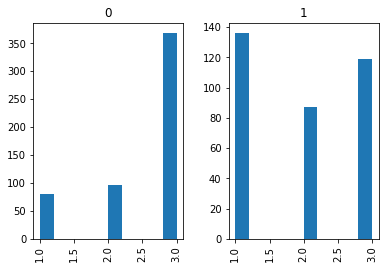

In [12]:
plt.figure()
titanic['Pclass'].hist(by=titanic['Survived'])

#### Barchart 'Age' vs 'Survive'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014BEC190AC8>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

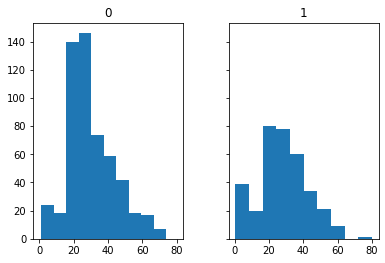

In [13]:
plt.figure()
titanic['Age'].hist(by=titanic['Survived'], sharex=True, sharey=True, xrot=0)

In [4]:
X = titanic[['Pclass', 'Sex', 'Age']]
y = titanic['Survived']

Note that the discrete/cts split below is necessary because we'll be training MultinomialNB on the former and GaussianNB on the latter. We will then sum the two log probabilities (by making a key adjustment, see below) to get a full NB classifier

Splitting dataset into train and test dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_cts = X_train[['Age']]
X_train_discrete = X_train[['Pclass', 'Sex']]

X_test_cts = X_test[['Age']]
X_test_discrete = X_test[['Pclass', 'Sex']]


In [8]:
print( "size of discrete train set is:", X_train_discrete.shape)
print( "size of discrete test set is:", X_test_discrete.shape)

size of discrete train set is: (709, 2)
size of discrete test set is: (178, 2)


Estimate of the two class frequencies, we'll need it later

In [9]:
pi_hat = y_train.value_counts()/len(y_train)
pi_hat

0    0.627645
1    0.372355
Name: Survived, dtype: float64

Fitting Gaussian NB to the continuous part of the dataset. We can see, variances and means are roughly equivalent. Normal assumption doesn't manage to capture the differences in the barchart above

In [11]:
model1 = GaussianNB()
model1.fit(X_train_cts, y_train)
print('class means for the model are:', model1.theta_)
print('class variances for the model are:', model1.sigma_)

class means for the model are: [[30.32359551]
 [29.36083333]]
class variances for the model are: [[189.28966816]
 [198.57890632]]


Calculating the conditional log likelihoods log(P(x_i|y)) = log(pi_0) + log( f(x_i|mean_0, var_0) )

In [14]:
log_prob_X_given_cts = model1.predict_log_proba(X_train_cts)
log_prob_X_given_cts

array([[-0.45665298, -1.00348423],
       [-0.4692586 , -0.9820722 ],
       [-0.47171102, -0.97799006],
       ...,
       [-0.47969317, -0.96488578],
       [-0.45323096, -1.00942442],
       [-0.49685774, -0.93761532]])

In [19]:
model2 = MultinomialNB()
model2.fit(X_train_discrete, y_train)



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
log_prob_X_given_discrete = model2.predict_log_proba(X_train_discrete)
log_prob_X_given_discrete

array([[-0.84373554, -0.56229588],
       [-1.14600871, -0.38258353],
       [-1.14600871, -0.38258353],
       ...,
       [-0.25302162, -1.49812507],
       [-0.25302162, -1.49812507],
       [-0.84373554, -0.56229588]])

In [24]:
print("second value from bottom should be 3rd class because log probability of survival is very low:")
print(X_train_discrete.iloc[-2, :])

second value from bottom should be 3rd class because log probability of survival is very low:
Pclass    3
Sex       0
Name: 765, dtype: int64


#### The key idea is here: because of independence assumption of NB; you can sum the two log-likelihoods. However in this case log(pi_hat) is summed twice, so must subtract it once

In [26]:
log_prob = log_prob_X_given_cts + log_prob_X_given_discrete
log_prob -= np.log(pi_hat)
log_prob.shape

(709, 2)

Predicting 1 is log_prob of class 1 is the greatest, 0 otherwise

In [34]:
y_predict = log_prob[:, 0] < log_prob[:, 1]
y_predict = y_predict.astype(int)
y_predict[:10]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

As anticipated, adding age doesn't change much because the two gaussian were almost identical

In [37]:
precision = sum(y_predict == y_train)/ len(y_train)
print("Correctly classified % for full model is:", precision)
precision2 = sum(model2.predict(X_train_discrete) == y_train) /len(y_train)
print("Correctly classified % for discrete model is:", precision2)
precision3 = sum(model1.predict(X_train_cts) == y_train) /len(y_train)
print("Correctly classified % for cts model is:", precision3)

Correctly classified % for full model is: 0.7870239774330042
Correctly classified % for discrete model is: 0.7870239774330042
Correctly classified % for cts model is: 0.6276445698166432


Now switching to test set, we can see that precision is unchanged

In [39]:
log_prob_X_given_cts = model1.predict_log_proba(X_test_cts)
log_prob_X_given_discrete = model2.predict_log_proba(X_test_discrete)
log_prob = log_prob_X_given_cts + log_prob_X_given_discrete
log_prob -= np.log(pi_hat)
y_predict = log_prob[:, 0] < log_prob[:, 1]
y_predict = y_predict.astype(int)



In [40]:
precision = sum(y_predict == y_test)/ len(y_test)
print("Correctly classified % for full model is:", precision)
precision2 = sum(model2.predict(X_test_discrete) == y_test) /len(y_test)
print("Correctly classified % for discrete model is:", precision2)
precision3 = sum(model1.predict(X_test_cts) == y_test) /len(y_test)
print("Correctly classified % for cts model is:", precision3)

Correctly classified % for full model is: 0.7808988764044944
Correctly classified % for discrete model is: 0.7808988764044944
Correctly classified % for cts model is: 0.5617977528089888
